# NLP project: Spooky Author Identification


Data Link: <https://www.kaggle.com/c/spooky-author-identification/data>

# Part 1. Exploratory Data Analysis

## Load packages and colors

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os, re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud

from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

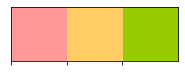

In [2]:
mycolors = ['#ff9999', '#ffcc66', '#99cc00']
sns.palplot(mycolors)

## Load data 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv('/content/drive/My Drive/spooky/train.csv',header=0)
test = pd.read_csv('/content/drive/My Drive/spooky/test.csv',header=0)
print(train.shape)
print(test.shape)

(19579, 3)
(8392, 2)


In [5]:
# preview dataset
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Target Distribution

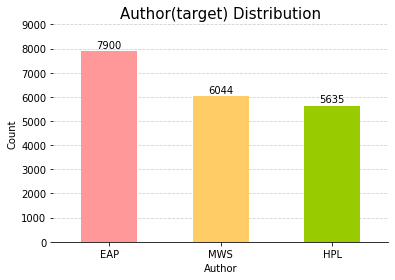

In [6]:
# target distribution
targets = train['author'].value_counts()
ax = targets.plot.bar(color = mycolors)

for i in range(3):
  plt.annotate(targets.values[i], xy = (i, targets.values[i] + 250), ha = 'center', va = 'center')

ax.set_xticklabels(targets.index, rotation = 0)
ax.set_ylim([0, 9000])
ax.set_xlabel('Author'); ax.set_ylabel('Count')
ax.set_title('Author(target) Distribution', fontsize = 15)

for i in ['left', 'right', 'top']:
  ax.spines[i].set_visible(False)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha = 0.6)

## Text Cleansing

In [7]:
# text cleansing
stopwords = nltk.corpus.stopwords.words('english')

def text_cleansing(text):
  # 특수문자 제거
  text = re.sub("[-=+,#/\?:^$.@*\"※~&%;ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", "", text)
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [token.strip() for token in tokens]

  new_tokens = [token for token in tokens if token not in stopwords]
  new_text = ' '.join(new_tokens)
  return new_text

train['new_text'] = train['text'].apply(text_cleansing)
train.head()

,id,text,author,new_text
0,id26305,"This process, however, afforded me no means of...",EAP,process however afforded means ascertaining di...
1,id17569,It never once occurred to me that the fumbling...,HPL,never occurred fumbling might mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else even gold superintendent ...


## Author: Edgar Allan Poe(EAP)

In [8]:
from collections import Counter

eap = train[train['author'] == 'EAP']
eap_text = ' '.join(eap['new_text'])
eap_count = Counter(eap_text.split())
eap_count = dict(eap_count)
eap_count_df = pd.DataFrame({'word': eap_count.keys(), 'freq': eap_count.values()}).sort_values(by = 'freq', ascending = False)
eap_top50 = eap_count_df[:50]

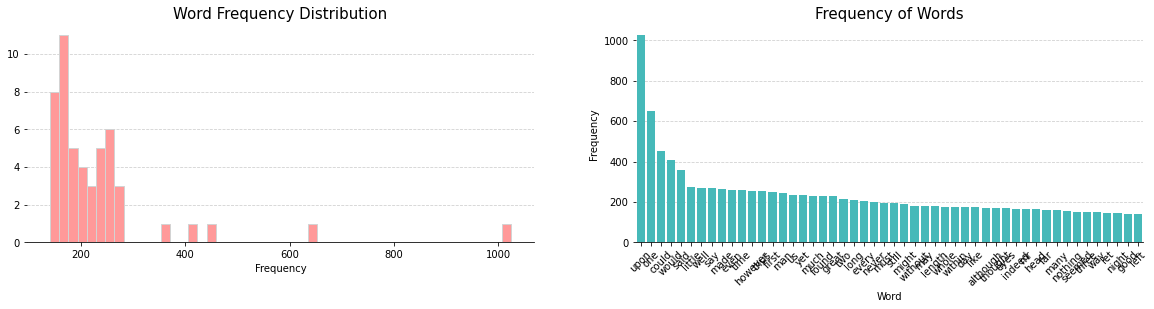

In [9]:
# define plot function
def plot_word_dist(data, color):
  fig, (ax1, ax2)  = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))
  ax1.hist(data['freq'], color = color, bins = 50, edgecolor = 'lightgrey')
  ax1.set_title('Word Frequency Distribution', fontsize = 15); ax1.set_xlabel('Frequency')
  sns.barplot(data.word, data.freq, ax = ax2, color = '#33cccc')
  ax2.set_title('Frequency of Words', fontsize = 15); ax2.set_xlabel('Word'); ax2.set_xticklabels(labels = data['word'], rotation = 45)
  ax2.set_ylabel('Frequency')

  for i in ['left', 'right', 'top']:
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)

  ax1.set_axisbelow(True)
  ax1.grid(axis='y', linestyle='--', alpha = 0.6)

  ax2.set_axisbelow(True)
  ax2.grid(axis='y', linestyle='--', alpha = 0.6)

  plt.show()


plot_word_dist(eap_top50, '#ff9999')

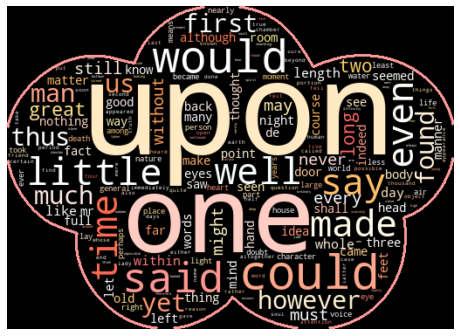

In [10]:
from PIL import Image

def eap_colors(word, font_size, position, orientation, random_state = None, **kwargs):
    return("hsl({:d}, {:d}%, {:d}%)".format(np.random.randint(0, 50), np.random.randint(100, 130), np.random.randint(70, 110)))


mask_img = np.array(Image.open('/content/drive/My Drive/spooky/cloud.png'))

wc1 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = '#ff9999',
                contour_width = 3)

wc1.generate_from_frequencies(eap_count)
wc1 = wc1.recolor(color_func = eap_colors, random_state = True) 

plt.figure(figsize = (8, 8))
plt.imshow(wc1, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Author: Mary Wollstonecrafe Shelley(MWS)

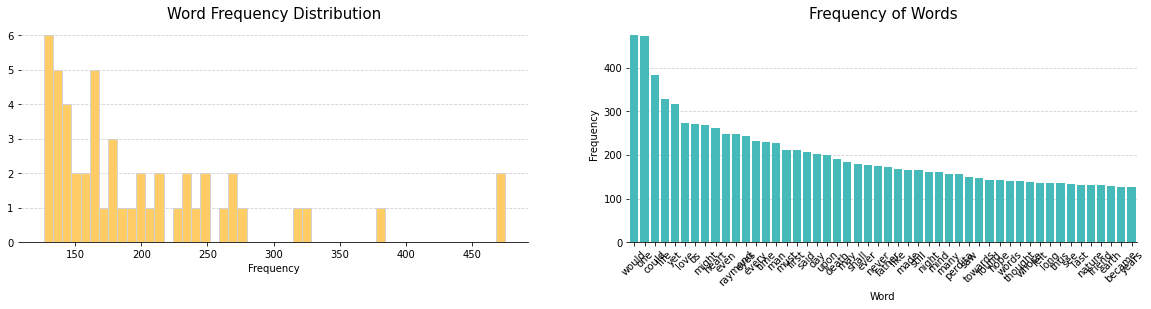

In [11]:
mws = train[train['author'] == 'MWS']
mws_text = ' '.join(mws['new_text'])
mws_count = Counter(mws_text.split())
mws_count = dict(mws_count)
mws_count_df = pd.DataFrame({'word': mws_count.keys(), 'freq': mws_count.values()}).sort_values(by = 'freq', ascending = False)
mws_top50 = mws_count_df[:50]

plot_word_dist(mws_top50, '#ffcc66')

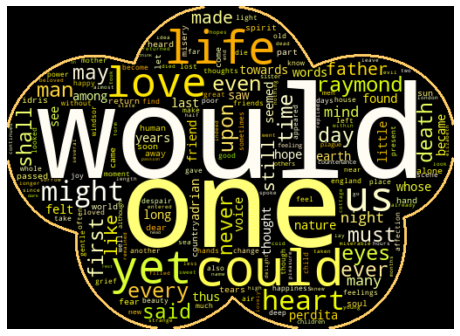

In [12]:
def mws_colors(word, font_size, position, orientation, random_state = None, **kwargs):
    return("hsl({:d}, {:d}%, {:d}%)".format(np.random.randint(40, 80), np.random.randint(100, 140), np.random.randint(40, 100)))


mask_img = np.array(Image.open('/content/drive/My Drive/spooky/cloud.png'))

wc2 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = mycolors[1],
                contour_width = 3)

wc2.generate_from_frequencies(mws_count)
wc2 = wc2.recolor(color_func = mws_colors, random_state = True) 

plt.figure(figsize = (8, 8))
plt.imshow(wc2, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Author: HP Lovecraft(HPL)

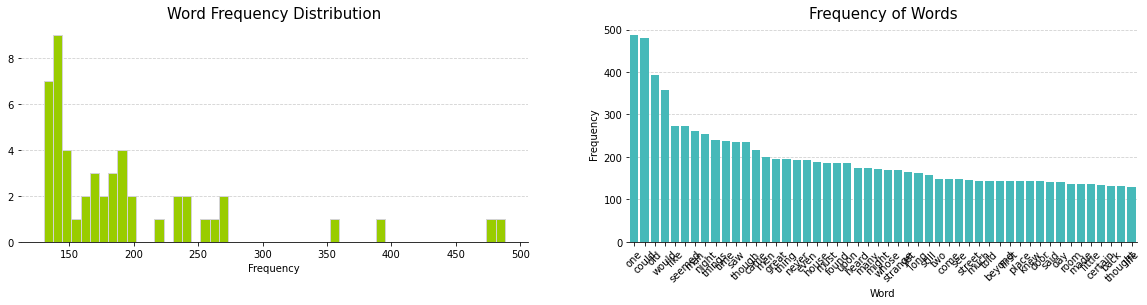

In [13]:
hpl = train[train['author'] == 'HPL']
hpl_text = ' '.join(hpl['new_text'])
hpl_count = Counter(hpl_text.split())
hpl_count = dict(hpl_count)
hpl_count_df = pd.DataFrame({'word': hpl_count.keys(), 'freq': hpl_count.values()}).sort_values(by = 'freq', ascending = False)
hpl_top50 = hpl_count_df[:50]

plot_word_dist(hpl_top50, mycolors[2])

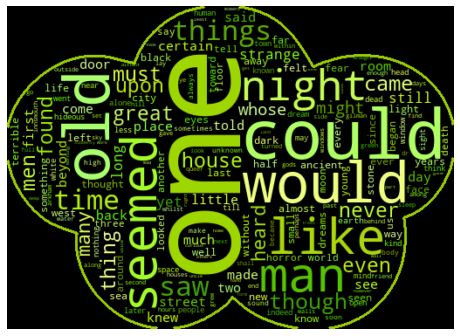

In [14]:
def hpl_colors(word, font_size, position, orientation, random_state = None, **kwargs):
    return("hsl({:d}, {:d}%, {:d}%)".format(np.random.randint(70, 100), np.random.randint(90, 120), np.random.randint(30, 80)))


mask_img = np.array(Image.open('/content/drive/My Drive/spooky/cloud.png'))

wc3 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = mycolors[2],
                contour_width = 3)

wc3.generate_from_frequencies(hpl_count)
wc3 = wc3.recolor(color_func = hpl_colors, random_state = True) 

plt.figure(figsize = (8, 8))
plt.imshow(wc3, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Check distribution of words in each author data

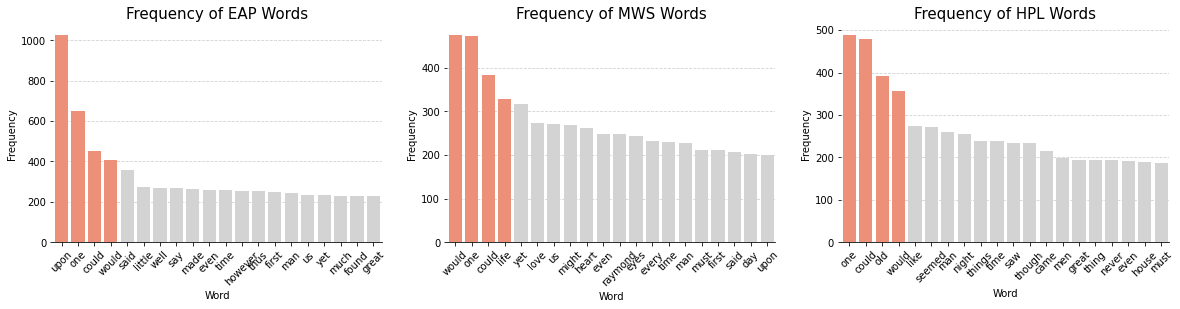

In [15]:
fig, (ax1, ax2, ax3)  = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))

colors = ['lightgrey']*20
for i in range(4):
  colors[i] = '#ff8566'

sns.barplot(eap_top50[:20].word, eap_top50[:20].freq, ax = ax1, palette = colors)

ax1.set_title('Frequency of EAP Words', fontsize = 15); ax1.set_xlabel('Word'); ax1.set_xticklabels(labels = eap_top50['word'], rotation = 45)
ax1.set_ylabel('Frequency')

sns.barplot(mws_top50[:20].word, mws_top50[:20].freq, ax = ax2, palette = colors)
ax2.set_title('Frequency of MWS Words', fontsize = 15); ax2.set_xlabel('Word'); ax2.set_xticklabels(labels = mws_top50['word'], rotation = 45)
ax2.set_ylabel('Frequency')

sns.barplot(hpl_top50[:20].word, hpl_top50[:20].freq, ax = ax3, palette = colors)
ax3.set_title('Frequency of HPL Words', fontsize = 15); ax3.set_xlabel('Word'); ax3.set_xticklabels(labels = hpl_top50['word'], rotation = 45)
ax3.set_ylabel('Frequency')

for i in ['left', 'right', 'top']:
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)

ax1.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha = 0.6)

ax2.set_axisbelow(True)
ax2.grid(axis='y', linestyle='--', alpha = 0.6)

ax3.set_axisbelow(True)
ax3.grid(axis='y', linestyle='--', alpha = 0.6)

plt.show()

In [16]:
# delete 'could', 'would', 'one'
del(eap_count['could'])
del(eap_count['would'])
del(eap_count['one'])

del(mws_count['could'])
del(mws_count['would'])
del(mws_count['one'])

del(hpl_count['could'])
del(hpl_count['would'])
del(hpl_count['one'])

## Word Cloud without stopwords based on word frequency

In [17]:
wc1 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = '#ff9999',
                contour_width = 3)

wc1.generate_from_frequencies(eap_count)
wc1 = wc1.recolor(color_func = eap_colors, random_state = True) 

wc2 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = mycolors[1],
                contour_width = 3)

wc2.generate_from_frequencies(mws_count)
wc2 = wc2.recolor(color_func = mws_colors, random_state = True) 

wc3 = WordCloud(max_font_size = 150, 
                stopwords = stopwords, 
                background_color = 'black', 
                width = 800, 
                height = 800,
                mask = mask_img,
                contour_color = mycolors[2],
                contour_width = 3)

wc3.generate_from_frequencies(hpl_count)
wc3 = wc3.recolor(color_func = hpl_colors, random_state = True) 

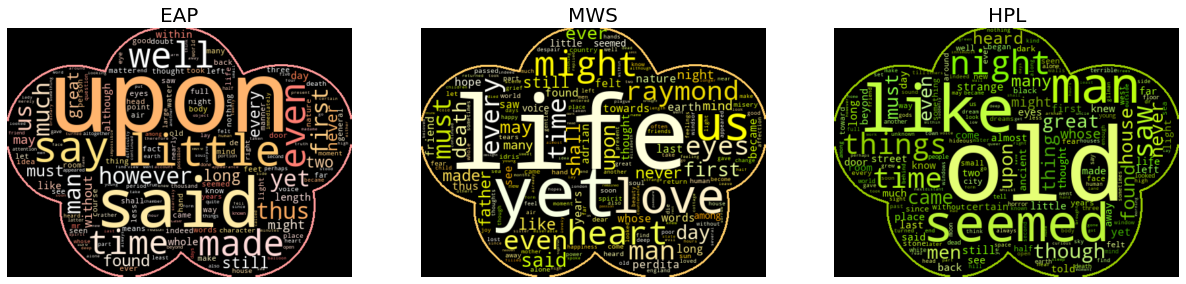

In [21]:
plt.figure(figsize = (21, 7))

plt.subplot(1, 3, 1)
plt.imshow(wc1, interpolation = 'bilinear')
plt.title('EAP', fontsize = 20)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wc2, interpolation = 'bilinear')
plt.title('MWS', fontsize = 20)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wc3, interpolation = 'bilinear')
plt.title('HPL', fontsize = 20)
plt.axis('off')

plt.show()